313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9723 - loss: 0.0919
Test accuracy on clean images: 0.9757999777793884


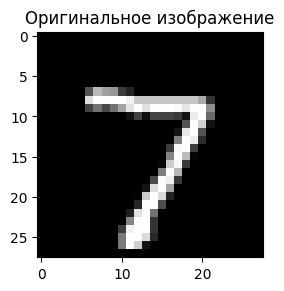

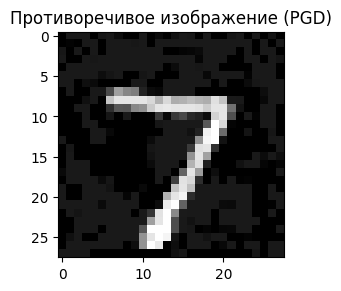

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0395 - loss: 8.2086
Accuracy on adversarial examples (PGD): 0.054499998688697815


In [3]:
%pip install foolbox
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('/content/sample_data/mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Выбор тестового изображения для атаки
image = tf.convert_to_tensor(test_images[0:1], dtype=tf.float32)
label = tf.convert_to_tensor(np.argmax(test_labels[0]), dtype=tf.int64)

# Создание атаки PGD
attack = fb.attacks.LinfPGD()
eager_adversial, _, success = attack(fmodel, image, label[None], epsilons=0.1)

# Визуализация исходного и атакованного изображения
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")

plt.figure()
plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (PGD)")
plt.imshow(eager_adversial[0].numpy(), cmap="gray")
plt.show()

# Создание набора противоречивых примеров для всего тестового набора
adversarial_images = []

for idx in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[idx:idx+1], dtype=tf.float32)
    label = tf.convert_to_tensor(np.argmax(test_labels[idx]), dtype=tf.int64)
    eager_adversial, _, success = attack(fmodel, image, label[None], epsilons=0.1)
    adversarial_images.append(eager_adversial[0].numpy())

adversarial_images = np.array(adversarial_images)

# Оценка точности модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on adversarial examples (PGD): {adversarial_acc}')


Вывод: модель демонстрирует высокую эффективность на тестовых данных в стандартных условиях, достигая точности 98%, однако под воздействием PGD-атаки её точность резко падает до 5%, что указывает на её уязвимость к целенаправленным изменениям входных данных. PGD-атака способна существенно повлиять на работоспособность моделей искусственного интеллекта.
